# 人脸识别比赛

### 数据集

1、上传zip格式压缩的数据集压缩包

2、运行`! unzip dataset.zip`

3、按上面的方法上传test.zip

4、将数据集放置在根目录下，与work目录同级

In [1]:
%matplotlib inline
import torch
import time
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import os  

import sys
sys.path.append("..") 
# import d2lzh_pytorch as d2l

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

In [2]:
def load_data_face(batch_size):
    transform = torchvision.transforms.Compose([
       # torchvision.transforms.Grayscale(num_output_channels=1), # 彩色图像转灰度图像num_output_channels默认1
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.Resize([330,330]),
        torchvision.transforms.CenterCrop([224, 224]),
        
        torchvision.transforms.ToTensor()
    ])
    train_imgs = torchvision.datasets.ImageFolder('./dataset/train', transform=transform)
    test_imgs = torchvision.datasets.ImageFolder('./dataset/test', transform=transform)
    train_iter = torch.utils.data.DataLoader(train_imgs, batch_size=batch_size, shuffle=True, num_workers=4)
    test_iter = torch.utils.data.DataLoader(test_imgs, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_iter, test_iter

In [3]:
batch_size = 32
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter = load_data_face(batch_size)

In [4]:
# 获取并保存人名和索引的对应关系，用于测试过程中将索引映射为人名
import pickle
transform = torchvision.transforms.Compose([
    #torchvision.transforms.Grayscale(num_output_channels=1), # 彩色图像转灰度图像num_output_channels默认1
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Resize([330,330]),
    torchvision.transforms.CenterCrop([224, 224]),
    torchvision.transforms.ToTensor()
])
test_imgs = torchvision.datasets.ImageFolder('./dataset/test', transform=transform)
label = test_imgs.class_to_idx
label = {value:key for key, value in label.items()}
# print(len(label))
# 写入文件
label_hal = open('label.pkl', 'wb')
s = pickle.dumps(label)
label_hal.write(s)
label_hal.close()

In [5]:
#修改net，pretrained，正则化

In [11]:
net=models.resnet50(pretrained=True)
# print(net)
net.fc = nn.Sequential(
                       nn.ReLU(),
                       nn.Dropout(0.6),
                       nn.Linear(2048, 311)
)

### 训练

In [7]:
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device 
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型, 3.13节之后不会用到, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n

In [8]:
train_acc_list = []
test_acc_list = []
def train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    loss = torch.nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
#         train_iter,test_iter1 = load_data_face(batch_size)
        test_acc = evaluate_accuracy(test_iter, net)
        train_acc_list.append(train_acc_sum / n)
        test_acc_list.append(test_acc)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [15]:
lr, num_epochs = 0.01,4
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,weight_decay=1e-4)
train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda:2
epoch 1, loss 0.7742, train acc 0.815, test acc 0.661, time 31.4 sec
epoch 2, loss 0.6757, train acc 0.829, test acc 0.669, time 30.0 sec
epoch 3, loss 0.4927, train acc 0.878, test acc 0.741, time 29.8 sec
epoch 4, loss 0.3249, train acc 0.922, test acc 0.803, time 30.2 sec


In [13]:
lr, num_epochs = 0.001,5
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.5,weight_decay=1e-4)
train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda:2
epoch 1, loss 1.0158, train acc 0.763, test acc 0.697, time 28.1 sec
epoch 2, loss 0.8901, train acc 0.800, test acc 0.724, time 27.7 sec
epoch 3, loss 0.8476, train acc 0.811, test acc 0.735, time 28.4 sec
epoch 4, loss 0.7879, train acc 0.822, test acc 0.749, time 27.9 sec
epoch 5, loss 0.7773, train acc 0.832, test acc 0.763, time 28.1 sec


In [14]:
lr, num_epochs = 0.0005,5
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,weight_decay=1e-4)
train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda:2
epoch 1, loss 0.7255, train acc 0.846, test acc 0.772, time 29.5 sec
epoch 2, loss 0.6788, train acc 0.864, test acc 0.784, time 30.3 sec
epoch 3, loss 0.6229, train acc 0.877, test acc 0.784, time 30.2 sec
epoch 4, loss 0.5861, train acc 0.880, test acc 0.793, time 30.5 sec
epoch 5, loss 0.5545, train acc 0.899, test acc 0.799, time 31.6 sec


In [10]:
net.parameters()

<generator object Module.parameters at 0x7f5dcc20d570>

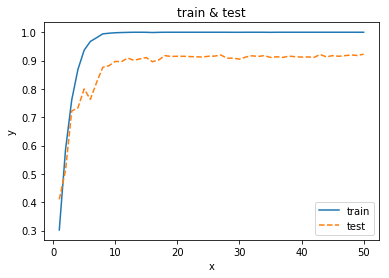

In [11]:
# 自己加个画图
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
x = np.arange(1, len(train_acc_list)+1, 1)
y1 = np.array(train_acc_list)
y2 = np.array(test_acc_list)
plt.plot(x, y1, label="train")
plt.plot(x, y2, linestyle = "--", label="test")
plt.xlabel("x")
plt.ylabel("y")
plt.title('train & test')
plt.legend()
plt.show()

### 保存模型

In [13]:
torch.save(net, './resnet50.pkl')

# 生成识别结果文件测试

In [11]:
# 读取训练好的模型
model = torch.load('./resnet50.pkl').eval()

In [29]:
# 获取本次训练的人名和索引的对应关系
label = {}
with open('label.pkl','rb') as file:
    label = pickle.loads(file.read())
# print(label)
# 测试集label对应关系
import pickle
label_answer = {}
with open('label_answer.pkl','rb') as file:
    label_answer = pickle.loads(file.read())
label_answer = {value:key for key, value in label_answer.items()}

In [35]:
# 加载测试数据（在test目录下）
from PIL import Image
import numpy as np

transform = torchvision.transforms.Compose([
#     torchvision.transforms.Grayscale(num_output_channels=1), # 彩色图像转灰度图像num_output_channels默认1
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.CenterCrop([224, 224]),
#     torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.ToTensor()
])
# 生成测试结果文件
path = os.listdir('test')
r_d = {}
for f in path:
#     print('test/' + f)
    img = Image.open('test/' + f)
    test_imgs = transform(img).unsqueeze(0)
    test_imgs = test_imgs.to(device)
    y = model(test_imgs)
    pred = torch.argmax(y, dim = 1)
    r = label_answer[label[int(pred)]]
    r_d[int(f.strip('.jpg'))] = r
#     print(1)
# 写入结果文件
r_d = sorted(r_d.items(), key=lambda a:a[0])
r_d = dict(r_d)
ret = open("result.csv","w")
for key, value in r_d.items():
    print("%d,%s"%(key, value), file=ret)
ret.close()

test/1015.jpg
1
test/102.jpg
1
test/1026.jpg
1
test/1035.jpg
1
test/104.jpg
1
test/1057.jpg
1
test/1070.jpg
1
test/1075.jpg
1
test/1084.jpg
1
test/1087.jpg
1
test/1106.jpg
1
test/1140.jpg
1
test/1148.jpg
1
test/1153.jpg
1
test/1162.jpg
1
test/1178.jpg
1
test/1183.jpg
1
test/1189.jpg
1
test/1200.jpg
1
test/125.jpg
1
test/1267.jpg
1
test/1269.jpg
1
test/1284.jpg
1
test/1286.jpg
1
test/1314.jpg
1
test/1334.jpg
1
test/1336.jpg
1
test/1351.jpg
1
test/1384.jpg
1
test/1409.jpg
1
test/1420.jpg
1
test/1422.jpg
1
test/1429.jpg
1
test/1465.jpg
1
test/147.jpg
1
test/1500.jpg
1
test/1502.jpg
1
test/1510.jpg
1
test/1521.jpg
1
test/1540.jpg
1
test/1545.jpg
1
test/1551.jpg
1
test/1560.jpg
1
test/157.jpg
1
test/1572.jpg
1
test/1577.jpg
1
test/1580.jpg
1
test/1582.jpg
1
test/1587.jpg
1
test/1592.jpg
1
test/1595.jpg
1
test/1599.jpg
1
test/1608.jpg
1
test/1617.jpg
1
test/1624.jpg
1
test/1639.jpg
1
test/1645.jpg
1
test/168.jpg
1
test/1689.jpg
1
test/1690.jpg
1
test/17.jpg
1
test/170.jpg
1
test/1706.jpg
1
t

In [25]:
# 根据生成识别文件的代码，自行编写main.py文件，要求文件可生成结果文件result.csv
# 已知的坑：main.py中需增加模型类的定义

# 测试main.py生成result.csv
!python main.py
# 生成后自行验证

1.0.0
0.2.1
cpu
3578.jpg
5109.jpg
1409.jpg
2896.jpg
3550.jpg
2869.jpg
2855.jpg
1384.jpg
1810.jpg
3791.jpg
3168.jpg
3154.jpg
3626.jpg
1970.jpg
2289.jpg
5294.jpg
4834.jpg
1794.jpg
1582.jpg
4388.jpg
5097.jpg
2920.jpg
1540.jpg
4410.jpg
1781.jpg
1971.jpg
229.jpg
375.jpg
407.jpg
3753.jpg
3035.jpg
1178.jpg
1420.jpg
2129.jpg
3551.jpg
2103.jpg
2665.jpg
1422.jpg
2467.jpg
1608.jpg
2507.jpg
4604.jpg
1026.jpg
5240.jpg
203.jpg
4823.jpg
2739.jpg
3427.jpg
5095.jpg
1595.jpg
3382.jpg
1580.jpg
3803.jpg
2274.jpg
2506.jpg
1153.jpg
2466.jpg
2314.jpg
2472.jpg
3591.jpg
1351.jpg
5137.jpg
3546.jpg
4567.jpg
3224.jpg
170.jpg
3754.jpg
4749.jpg
5319.jpg
3797.jpg
2270.jpg
5286.jpg
3807.jpg
1976.jpg
548.jpg
5053.jpg
2066.jpg
4833.jpg
2339.jpg
4748.jpg
4984.jpg
1624.jpg
2846.jpg
4576.jpg
3543.jpg
2887.jpg
826.jpg
2663.jpg
3569.jpg
5332.jpg
4038.jpg
1140.jpg
2475.jpg
3780.jpg
1183.jpg
588.jpg
577.jpg
2298.jpg
5291.jpg
3804.jpg
2071.jpg
946.jpg
1587.jpg
1592.jpg
4367.jpg
953.jpg
1551.jpg
1545.jpg
3434.jpg
5284.jpg
210.j